In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
#https://www.tensorflow.org/tutorials/images/classification

In [3]:
import pathlib
dataset_url="https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir=tf.keras.utils.get_file("flower_photos",origin=dataset_url, untar=True)
data_dir=pathlib.Path(data_dir)

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


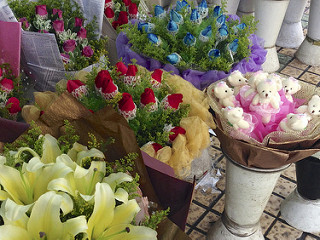

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[28]))

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
#split data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2, #buat nentuin brp banyak buat training sm buat training
    subset = "training",
    seed = 123, #buat randomized
    image_size = (img_height,img_width),
    batch_size=batch_size #batch size buat brp banyak data di training
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [21]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [8]:
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

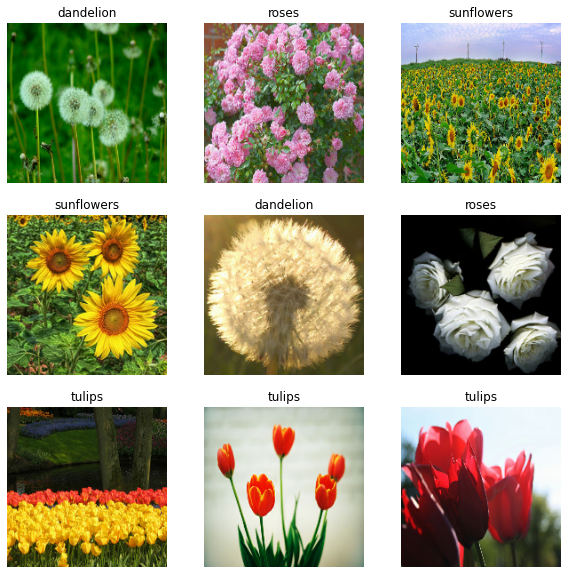

In [11]:
#visualisasi data
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [12]:
#iterasi manual data
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [23]:
#standarisasi dan normalisasi
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 1.0


In [24]:
#buat model
num_classes = 5
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height,img_width,3)),
    layers.Conv2D(16,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [25]:
#compile
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 64)       

In [27]:
#train model
epochs = 10
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/10
92/92 [==============================] - 181s 2s/step - loss: 1.2913 - accuracy: 0.4690 - val_loss: 1.1262 - val_accuracy: 0.5490
Epoch 2/10
92/92 [==============================] - 150s 2s/step - loss: 0.9603 - accuracy: 0.6161 - val_loss: 0.9949 - val_accuracy: 0.5954
Epoch 3/10
92/92 [==============================] - 135s 1s/step - loss: 0.7558 - accuracy: 0.7142 - val_loss: 0.8942 - val_accuracy: 0.6471
Epoch 4/10
92/92 [==============================] - 156s 2s/step - loss: 0.5762 - accuracy: 0.7861 - val_loss: 0.9145 - val_accuracy: 0.6349
Epoch 5/10
92/92 [==============================] - 133s 1s/step - loss: 0.3717 - accuracy: 0.8610 - val_loss: 0.9444 - val_accuracy: 0.6635
Epoch 6/10
92/92 [==============================] - 134s 1s/step - loss: 0.1840 - accuracy: 0.9404 - val_loss: 1.2626 - val_accuracy: 0.6376
Epoch 7/10
92/92 [==============================] - 133s 1s/step - loss: 0.1101 - accuracy: 0.9687 - val_loss: 1.3404 - val_accuracy: 0.6785
Epoch 8/10
92

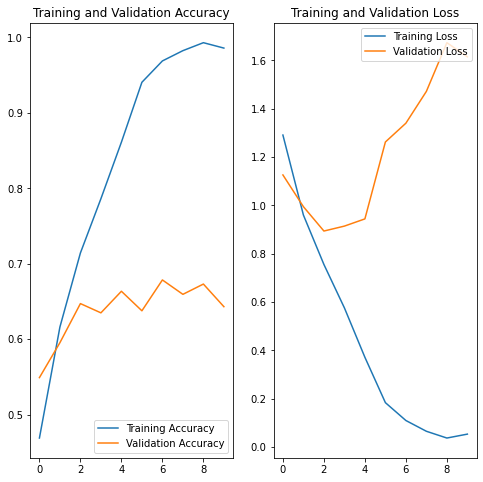

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
#data augmentation dapat membenarkan overfitting
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

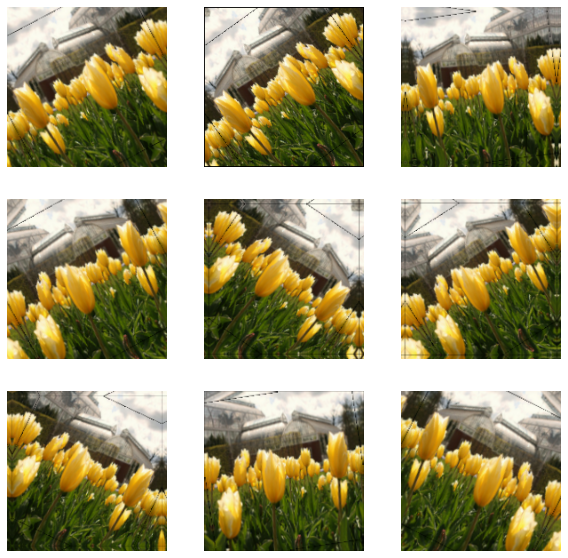

In [30]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [31]:
#dropout untuk mengurangi overfit
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [32]:
#compile dan train model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)       

In [34]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 204s 2s/step - loss: 1.3227 - accuracy: 0.4261 - val_loss: 1.1112 - val_accuracy: 0.5763
Epoch 2/15
92/92 [==============================] - 173s 2s/step - loss: 1.0307 - accuracy: 0.5954 - val_loss: 0.9621 - val_accuracy: 0.6158
Epoch 3/15
92/92 [==============================] - 157s 2s/step - loss: 0.9496 - accuracy: 0.6257 - val_loss: 0.9804 - val_accuracy: 0.6117
Epoch 4/15
92/92 [==============================] - 159s 2s/step - loss: 0.8661 - accuracy: 0.6649 - val_loss: 0.9129 - val_accuracy: 0.6349
Epoch 5/15
92/92 [==============================] - 159s 2s/step - loss: 0.8095 - accuracy: 0.6969 - val_loss: 0.8586 - val_accuracy: 0.6608
Epoch 6/15
92/92 [==============================] - 158s 2s/step - loss: 0.7656 - accuracy: 0.7074 - val_loss: 1.0038 - val_accuracy: 0.6485
Epoch 7/15
92/92 [==============================] - 156s 2s/step - loss: 0.7341 - accuracy: 0.7180 - val_loss: 0.8610 - val_accuracy: 0.6703
Epoch 8/15
92

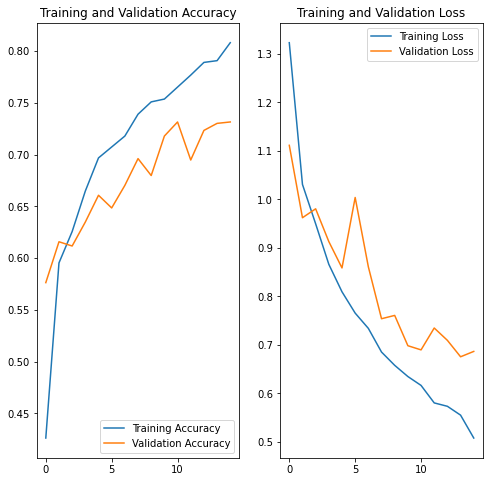

In [35]:
#visualisasi hasil train
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
#predict
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

122880/117948 [===============================] - 0s 0us/step
This image most likely belongs to sunflowers with a 97.86 percent confidence.
